In [ ]:
#import npm
import pip

In [ ]:
! python -m pip install /Users/sienkadounia/lab/ai-futures/Project/devinterp

Processing ./devinterp
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for devinterp: filename=devinterp-0.1.0-py3-none-any.whl size=29193 sha256=279aa7d2bc504bfd24a99bc8e860e34994e75e4c0a0bc7bb333d8344129a7d7e
  Stored in directory: /private/var/folders/z1/4ncpvz_901x1gm_4cv8jlcwr0000gn/T/pip-ephem-wheel-cache-9eblsxq8/wheels/d1/77/c6/79d956127053bf417b2be69c96cf13206452a78ec4d772f07c
Successfully built devinterp
  Attempting uninstall: devinterp
    Found existing installation: devinterp 0.1.0
    Uninstalling devinterp-0.1.0:
      Successfully uninstalled devinterp-0.1.0


In [ ]:
import torch
import numpy as np
import seaborn
import yaml
#import devinterp
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import copy
from torch import optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import devinterp
from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.slt.llc import estimate_learning_coeff_with_summary, sample
from devinterp.slt.mala import MalaAcceptanceRate
from devinterp.optim.sgld import SGLD
from devinterp.utils import plot_trace

In [ ]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

device = 'mps' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Let's define all the hyperparameters
use_adam_op = True
augmented = True
use_label_noise = True
pytorch_default_resnet = False
on_colab = False
model_width = 64
num_classes = 10
noise_levels = [0.10, 0.15, 0.20]
batch_size = 500
lr = 0.0001
epochs = 2000
model_seed = 42
data_seed = 42

In [ ]:
## ResNet18 for CIFAR
## Based on: https://gitlab.com/harvard-machine-learning/double-descent/-/blob/master/models/resnet18k.py

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, **kwargs):
        super(PreActBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                          nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.bn1(x)
        out = self.relu(out)
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, init_channels):
        super(PreActResNet, self).__init__()
        self.in_planes = init_channels
        c = init_channels

        self.conv1 = nn.Conv2d(3, c, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(c)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = self._make_layer(block, c, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*c, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*c, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*c, num_blocks[3], stride=2)
        self.avpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(8*c*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        # eg: [2, 1, 1, ..., 1]. Only the first one downsamples.
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def make_resnet18k(k, num_classes) -> PreActResNet:
    ''' Returns a ResNet18 with width parameter k. (k=64 is standard ResNet18)'''
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=num_classes, init_channels=k)

In [ ]:
# Let's import the CIFAR10 dataset from torchvision
transform = transforms.Compose([transforms.ToTensor()]) if not augmented else transforms.Compose([transforms.ToTensor(), transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if data_seed is not None:
    torch.manual_seed(data_seed)

train_set = datasets.CIFAR10(root='./data',
                             train=True,
                             download=True,
                             transform=transform)
trainloader = DataLoader(train_set,
                         batch_size=batch_size,
                         shuffle=True
                         )

test_set = datasets.CIFAR10(root='./data',
                            train=False,
                            download=True,
                            transform=transform)
testloader = DataLoader(test_set,
                        shuffle=False,
                        batch_size=batch_size
                        )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Preparing the indices to add label noise and cross-check
num_affected_labels_per_level = []
for i in noise_levels:
    num_noise = int(i * len(trainloader.dataset.data)) # total number of samples to be affected with current noise level
    num_affected_labels_per_level.append(num_noise)
    print(f'For {i} noise level, the total number of noisy labels is: {num_noise}')

For 0.1 noise level, the total number of noisy labels is: 5000
For 0.15 noise level, the total number of noisy labels is: 7500
For 0.2 noise level, the total number of noisy labels is: 10000


In [ ]:
all_corrupt_indices = []
affected_labels_per_level = []
all_check_labels = []
level_paths = ['label_noise/ten_percent_label_noise.csv', 'label_noise/fifteen_percent_label_noise.csv', 'label_noise/twenty_percent_label_noise.csv']
for i in range(len(noise_levels)):
    true_targets = trainloader.dataset.targets
    labels = copy.deepcopy(np.array(true_targets))
    np.random.seed(data_seed)
    corrupt_indices = np.random.permutation(len(true_targets))[:num_affected_labels_per_level[i]]
    all_corrupt_indices.append(corrupt_indices)
    check_labels = labels[corrupt_indices].tolist()
    all_check_labels.append(check_labels)
    loaded_labels = pd.read_csv(level_paths[i]).values
    loaded_labels = loaded_labels.squeeze()
    labels[corrupt_indices]= np.array(loaded_labels)
    affected_labels_per_level.append(labels[corrupt_indices])

model = make_resnet18k(model_width, num_classes)

file_path = '/Volumes/New/slt_of_dd/ewdd/'
selected_checkpoint = file_path + 'noise_' + '10' + 'checkpoint-with-noise' + '1999' +'.pth'
checkpoint = torch.load(selected_checkpoint)
model.load_state_dict(checkpoint['model_state'])
model.eval()

EPSILONS = [1e-4, 3e-5, 1e-5, 1e-6, 1e-7]
GAMMAS = [100.0, 1.0]
NUM_CHAINS = 1
NUM_DRAWS = 500
results = {}


def estimate_mala_sweeper(model):
    for epsilon in EPSILONS:
        for gamma in GAMMAS:
            mala_estimator = MalaAcceptanceRate(
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                num_samples=len(train_set),
                learning_rate=epsilon,
                device=device,
            )

            result = estimate_learning_coeff_with_summary(
                model,
                trainloader,
                criterion=criterion,
                optimizer_kwargs=dict(
                    lr=epsilon, elasticity=gamma, num_samples=len(train_set)
                ),
                sampling_method=SGLD,
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                callbacks=[mala_estimator],
                verbose=False,
                online=True,
            )
            mala_acceptance_rate_mean = mala_estimator.sample()["mala_accept/mean"]
            results[(epsilon, gamma)] = result
            print(
                f"epsilon {epsilon}, gamma {gamma}, mala rate: {mala_acceptance_rate_mean}"
            )


estimate_mala_sweeper(model)

In [ ]:
models = []

for i in range(len(noise_levels)):
  model = make_resnet18k(model_width, num_classes)
  checkpoint= torch.load('ewdd/noise_' + str(int(100*noise_levels[i]))+'checkpoint-with-noise1999.pth', map_location=device)
  model.load_state_dict(checkpoint['model_state'])
  models.append(model)

In [ ]:
trainloaders= []
use_test_label_noise = True
for i in range(len(noise_levels)):
    if use_label_noise:
        true_targets = trainloader.dataset.targets
        labels = copy.deepcopy(np.array(true_targets))
        labels[all_corrupt_indices[i]] = affected_labels_per_level[i]
        trainloader.dataset.targets = labels.tolist()
        trainloaders.append(trainloader)

In [ ]:
EPSILONS = [3e-5, 1e-5, 1e-6, 1e-7]
GAMMAS = [10.0]
NUM_CHAINS = 1
NUM_DRAWS = 500
results = {}

for i in range(len(noise_levels)):
    print(f'Running MALA calibration for ResNet Model with noise_level: {noise_levels[i]}')
    model = models[i]
    trainloader = trainloaders[i]
    criterion = nn.CrossEntropyLoss(reduction='mean').to(device)

    def estimate_mala_sweeper(model):
        for epsilon in EPSILONS:
            for gamma in GAMMAS:
                mala_estimator = MalaAcceptanceRate(
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    num_samples=len(train_set),
                    learning_rate=epsilon,
                    device=device,
                )

                result = estimate_learning_coeff_with_summary(
                    model,
                    trainloader,
                    criterion=criterion,
                    optimizer_kwargs=dict(
                        lr=epsilon, elasticity=gamma, num_samples=len(train_set)
                    ),
                    sampling_method=SGLD,
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    callbacks=[mala_estimator],
                    verbose=False,
                    online=True,
                )
                mala_acceptance_rate_mean = mala_estimator.sample()["mala_accept/mean"]
                results[(epsilon, gamma)] = result
                print(
                    f"epsilon {epsilon}, gamma {gamma}, mala rate: {mala_acceptance_rate_mean}"
                )
    estimate_mala_sweeper(model)

Running MALA calibration for ResNet Model with noise_level: 0.1


/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/devinterp/slt/sampler.py:50: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(


epsilon 3e-05, gamma 10.0, mala rate: 0.020040079951286316
epsilon 1e-05, gamma 10.0, mala rate: 0.1704537272453308
epsilon 1e-06, gamma 10.0, mala rate: 0.5072001218795776
epsilon 1e-07, gamma 10.0, mala rate: 0.48719361424446106
Running MALA calibration for ResNet Model with noise_level: 0.15
epsilon 3e-05, gamma 10.0, mala rate: 0.010020039975643158
epsilon 1e-05, gamma 10.0, mala rate: 0.16486568748950958
epsilon 1e-06, gamma 10.0, mala rate: 0.4989979863166809
epsilon 1e-07, gamma 10.0, mala rate: 0.47718968987464905
Running MALA calibration for ResNet Model with noise_level: 0.2
epsilon 3e-05, gamma 10.0, mala rate: 0.006012023892253637
epsilon 1e-05, gamma 10.0, mala rate: 0.10061406344175339
epsilon 1e-06, gamma 10.0, mala rate: 0.151183620095253
epsilon 1e-07, gamma 10.0, mala rate: 0.36342206597328186


In [ ]:
def plot_single_graph(result, title=""):
    llc_color = "teal"
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result["loss/trace"]
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result["llc/means"]
    stds = result["llc/stds"]
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx()
    axs2.plot(
        sgld_steps,
        means,
        color=llc_color,
        linestyle="--",
        linewidth=2,
        label=f"llc",
        zorder=3,
    )
    axs2.fill_between(
        sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2
    )

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel("SGLD time step")
    axs.set_ylabel("loss")
    axs2.set_ylabel("llc", color=llc_color)
    axs2.tick_params(axis="y", labelcolor=llc_color)
    axs.axhline(color="black", linestyle=":")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_sweep_single_model(results, to_test, name, **kwargs):
    llc_color = "teal"
    fig, axs = plt.subplots(len(to_test))

    for i, test_value in enumerate(to_test):
        result = results[(test_value)]
        # plot loss traces
        loss_traces = result["loss/trace"]
        for trace in loss_traces:
            init_loss = trace[0]
            zeroed_trace = trace - init_loss
            sgld_steps = list(range(len(trace)))
            axs[i].plot(sgld_steps, zeroed_trace)

        # plot llcs
        means = result["llc/means"]
        stds = result["llc/stds"]
        sgld_steps = list(range(len(means)))
        axs2 = axs[i].twinx()
        axs2.plot(
            sgld_steps,
            means,
            color=llc_color,
            linestyle="--",
            linewidth=2,
            label=f"llc",
            zorder=3,
        )
        axs2.fill_between(
            sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2
        )

        # center zero, assume zero is in the range of both y axes already
        y1_min, y1_max = axs[i].get_ylim()
        y2_min, y2_max = axs2.get_ylim()
        y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
        y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
        percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
        y1_amt_to_add = (y1_max - y1_min) * percent_to_add
        y2_amt_to_add = (y2_max - y2_min) * percent_to_add
        if y1_zero_ratio < y2_zero_ratio:
            # add to bottom of y1 and top of y2
            y1_min -= y1_amt_to_add
            y2_max += y2_amt_to_add
        elif y2_zero_ratio < y1_zero_ratio:
            # add to bottom of y2 and top of y1
            y2_min -= y2_amt_to_add
            y1_max += y1_amt_to_add
        axs[i].set_ylim(y1_min, y1_max)
        axs2.set_ylim(y2_min, y2_max)

        axs[i].set_title(f"${name}$ = {test_value}")
        # only show x axis label on last row
        if i == len(to_test) - 1:
            axs[i].set_xlabel("SGLD time step")
        axs[i].set_ylabel("loss")
        axs2.set_ylabel("llc", color=llc_color)
        axs2.tick_params(axis="y", labelcolor=llc_color)
    if kwargs.get("title"):
        fig.suptitle(kwargs["title"], fontsize=16)
    plt.tight_layout()
    plt.show()

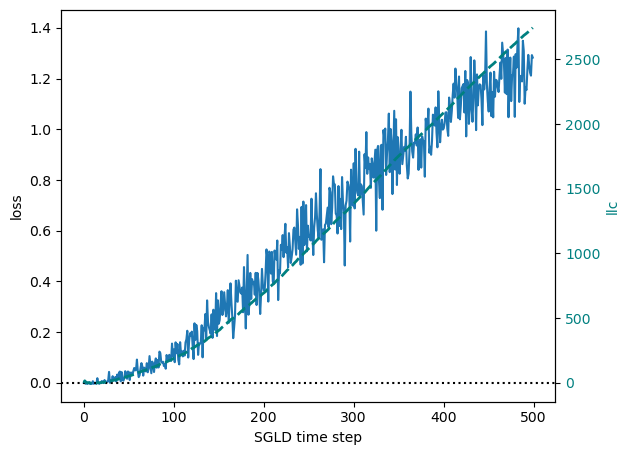

In [ ]:
epsilon = 1e-5
gamma = 10.0
result = results[(epsilon, gamma)]
plot_single_graph(result)

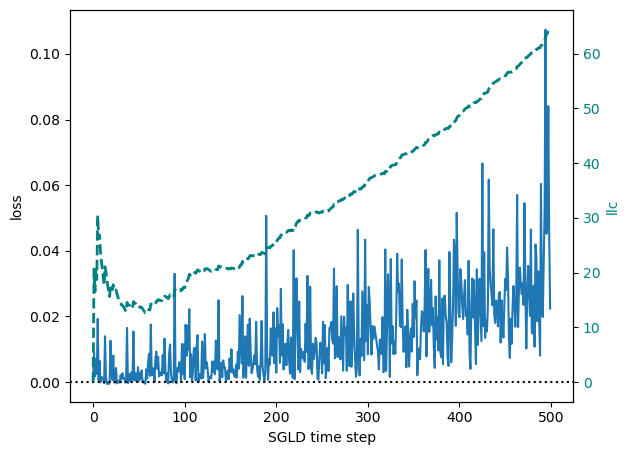

In [ ]:
epsilon = 1e-6
gamma = 10.0
result = results[(epsilon, gamma)]
plot_single_graph(result)

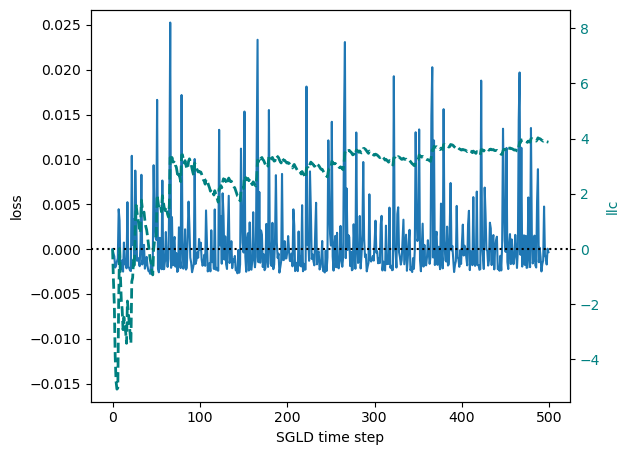

In [ ]:
epsilon = 1e-7
gamma = 10.0
result = results[(epsilon, gamma)]
plot_single_graph(result)

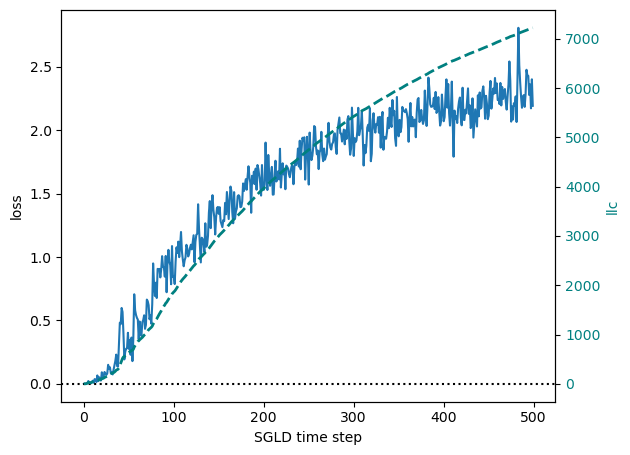

In [ ]:
epsilon = 3e-5
gamma = 10.0
result = results[(epsilon, gamma)]
plot_single_graph(result)

In [ ]:
EPSILONS = [3e-5, 1e-5, 1e-6, 1e-7]
GAMMAS = [10.0]
NUM_CHAINS = 1
NUM_DRAWS = 1000
results_1 = []

for i in range(len(noise_levels)):
    print(f'Running MALA calibration for ResNet Model with noise_level: {noise_levels[i]}')
    model = models[i]
    trainloader = trainloaders[i]
    criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
    results_2 = {}
    def estimate_mala_sweeper(model):
        for epsilon in EPSILONS:
            for gamma in GAMMAS:
                mala_estimator = MalaAcceptanceRate(
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    num_samples=len(train_set),
                    learning_rate=epsilon,
                    device=device,
                )

                result = estimate_learning_coeff_with_summary(
                    model,
                    trainloader,
                    criterion=criterion,
                    optimizer_kwargs=dict(
                        lr=epsilon, elasticity=gamma, num_samples=len(train_set)
                    ),
                    sampling_method=SGLD,
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    callbacks=[mala_estimator],
                    verbose=False,
                    online=True,
                )
                mala_acceptance_rate_mean = mala_estimator.sample()["mala_accept/mean"]
                results_2[(epsilon, gamma)] = result
                print(
                    f"epsilon {epsilon}, gamma {gamma}, mala rate: {mala_acceptance_rate_mean}"
                )
    estimate_mala_sweeper(model)
    results_1.append(results_2)

Running MALA calibration for ResNet Model with noise_level: 0.1


/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/devinterp/slt/sampler.py:50: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(


epsilon 3e-05, gamma 10.0, mala rate: 0.07912412285804749
epsilon 1e-05, gamma 10.0, mala rate: 0.2174968421459198
epsilon 1e-06, gamma 10.0, mala rate: 0.4818339943885803
epsilon 1e-07, gamma 10.0, mala rate: 0.5065944790840149
Running MALA calibration for ResNet Model with noise_level: 0.15
epsilon 3e-05, gamma 10.0, mala rate: 0.04312717914581299
epsilon 1e-05, gamma 10.0, mala rate: 0.17624111473560333
epsilon 1e-06, gamma 10.0, mala rate: 0.4995233416557312
epsilon 1e-07, gamma 10.0, mala rate: 0.5319871306419373
Running MALA calibration for ResNet Model with noise_level: 0.2
epsilon 3e-05, gamma 10.0, mala rate: 0.06707597523927689
epsilon 1e-05, gamma 10.0, mala rate: 0.16243353486061096
epsilon 1e-06, gamma 10.0, mala rate: 0.24802429974079132
epsilon 1e-07, gamma 10.0, mala rate: 0.3834250569343567


In [ ]:
torch.save(results_1, 'results_1.pt')

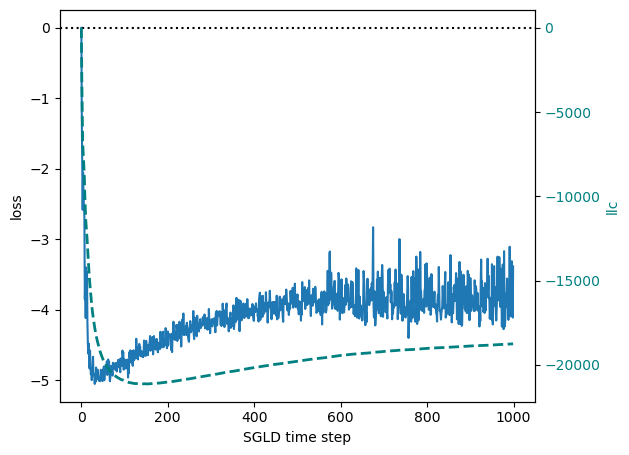

In [ ]:
epsilon = 3e-5
gamma = 10.0
results = results_1[0]
result = results[(epsilon, gamma)]
plot_single_graph(result)

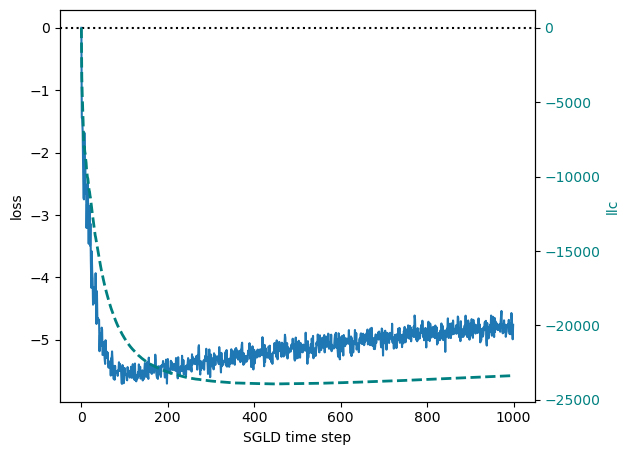

In [ ]:
epsilon = 1e-5
gamma = 10.0
results = results_1[0]
result = results[(epsilon, gamma)]
plot_single_graph(result)

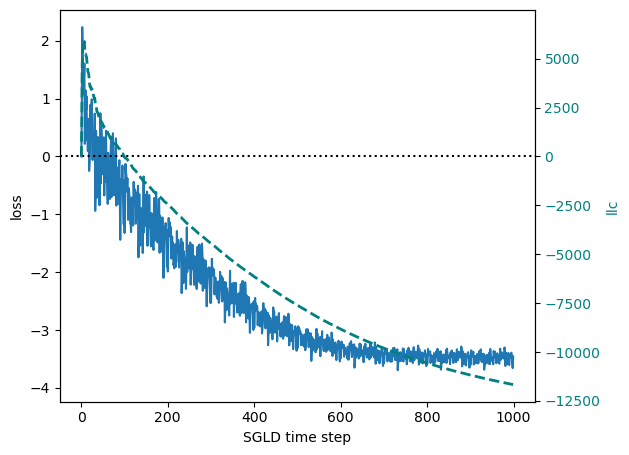

In [ ]:
epsilon = 1e-6
gamma = 10.0
results = results_1[0]
result = results[(epsilon, gamma)]
plot_single_graph(result)

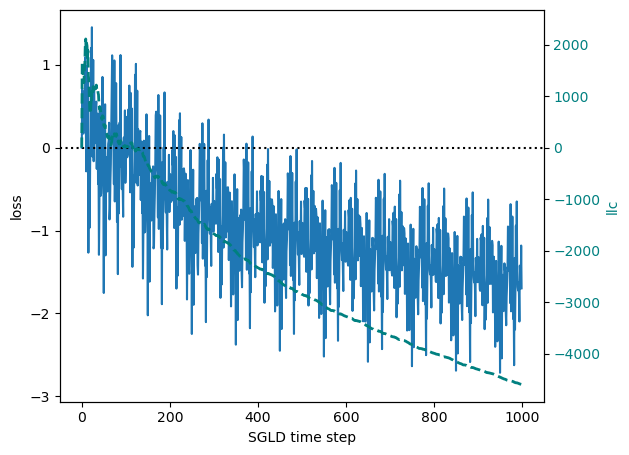

In [ ]:
epsilon = 1e-7
gamma = 10.0
results = results_1[0]
result = results[(epsilon, gamma)]
plot_single_graph(result)

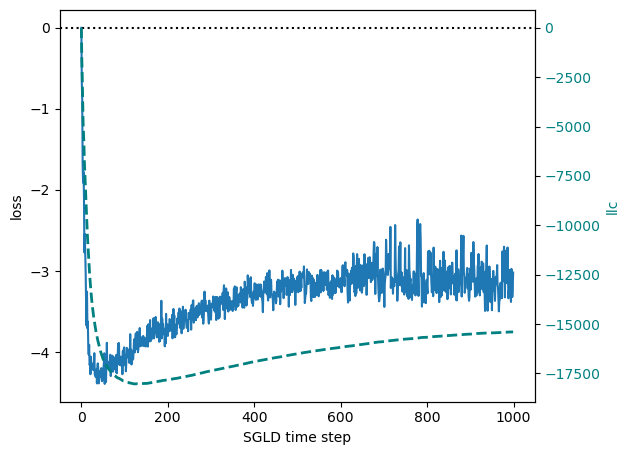

In [ ]:
epsilon = 3e-5
gamma = 10.0
results = results_1[1]
result = results[(epsilon, gamma)]
plot_single_graph(result)

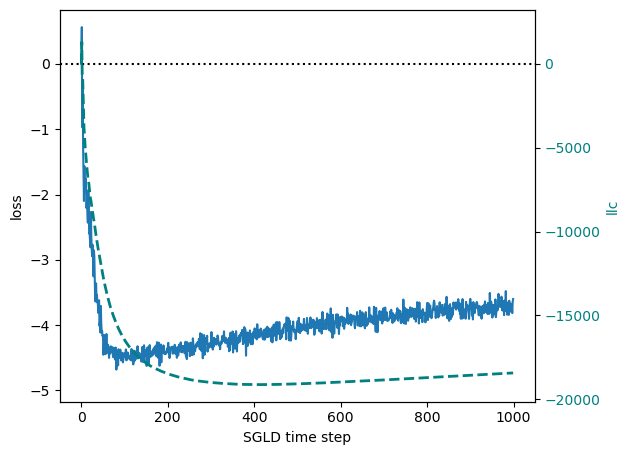

In [ ]:
epsilon = 1e-5
gamma = 10.0
results = results_1[1]
result = results[(epsilon, gamma)]
plot_single_graph(result)

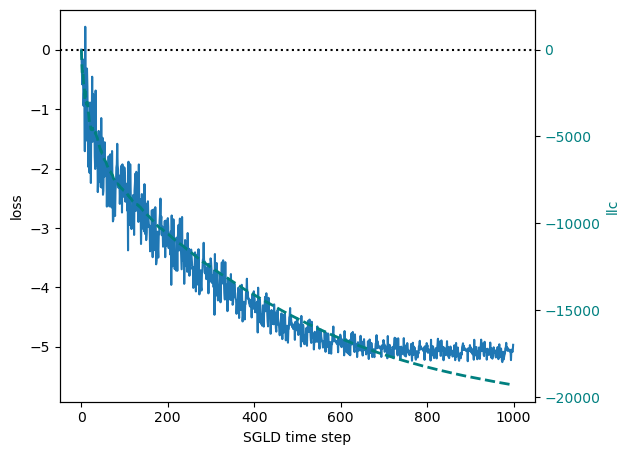

In [ ]:
epsilon = 1e-6
gamma = 10.0
results = results_1[1]
result = results[(epsilon, gamma)]
plot_single_graph(result)

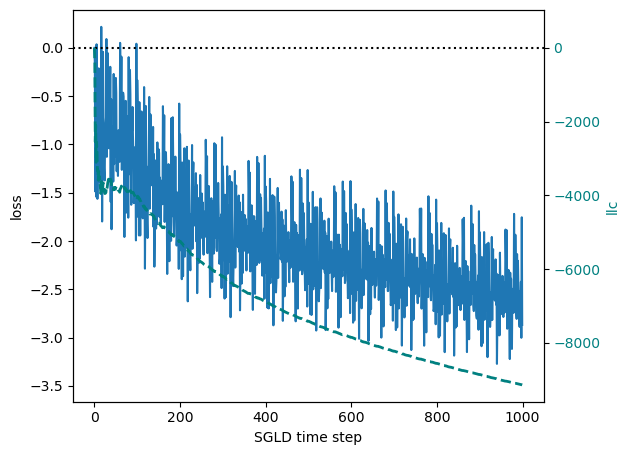

In [ ]:
epsilon = 1e-7
gamma = 10.0
results = results_1[1]
result = results[(epsilon, gamma)]
plot_single_graph(result)

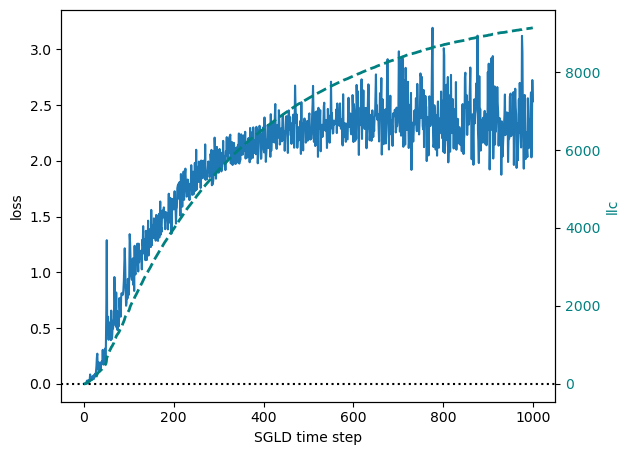

In [ ]:
epsilon = 3e-5
gamma = 10.0
results = results_1[2]
result = results[(epsilon, gamma)]
plot_single_graph(result)

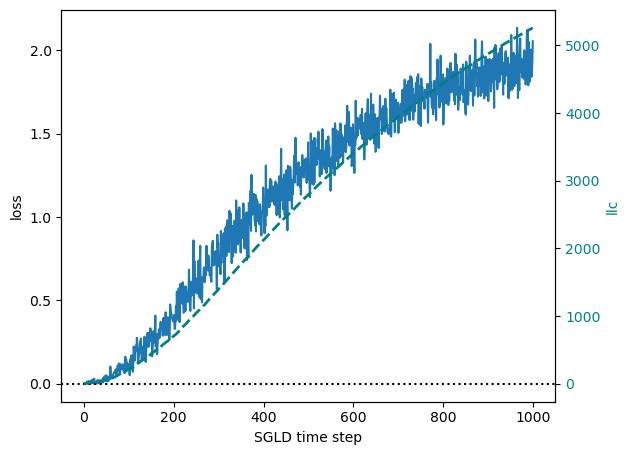

In [ ]:
epsilon = 1e-5
gamma = 10.0
results = results_1[2]
result = results[(epsilon, gamma)]
plot_single_graph(result)

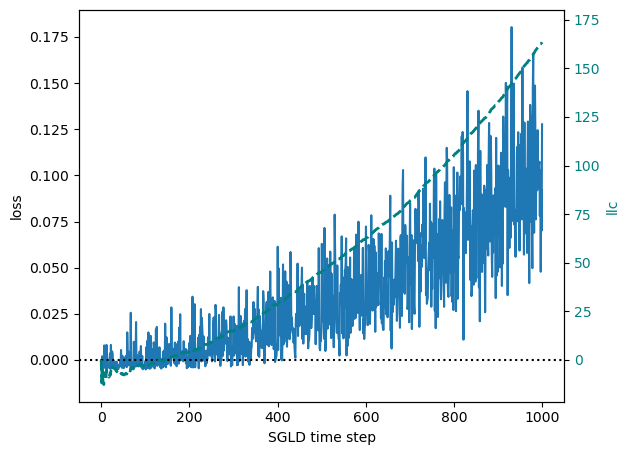

In [ ]:
epsilon = 1e-6
gamma = 10.0
results = results_1[2]
result = results[(epsilon, gamma)]
plot_single_graph(result)

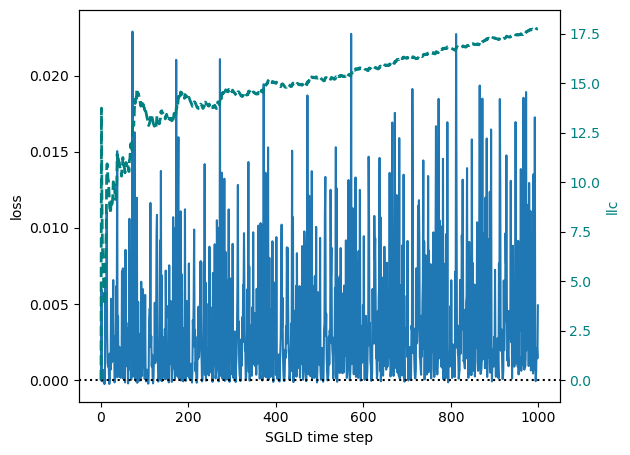

In [ ]:
epsilon = 1e-7
gamma = 10.0
results = results_1[2]
result = results[(epsilon, gamma)]
plot_single_graph(result)

In [ ]:
checkpoints_path = '/Volumes/New/slt_of_dd/ewdd/'
#checkpoints_per_path = '/content/gdrive/My Drive/checkpoints_per/'
rlcts_path = '/Users/sienkadounia/lab/checkpoints/rlcts/ewdd/'

In [ ]:
indice_list_1 = list(range(0, 100, 10))
indice_list_1

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [ ]:
# Let's define all the hyperparameters
use_adam_op = True
augmented = True
use_label_noise = True
pytorch_default_resnet = False
on_colab = False
model_width = 64
num_classes = 10
noise_levels = [0.10, 0.15, 0.20]
batch_size = 1000
epochs = 2000
model_seed = 42
data_seed = 42

NUM_CHAINS = 10
NUM_DRAWS = 1000

In [ ]:
plt.rcParams["figure.figsize"]=15,12  # note: this cell may need to be re-run after creating a plot to take effect

In [ ]:
# Let's import the CIFAR10 dataset from torchvision
transform = transforms.Compose([transforms.ToTensor()]) if not augmented else transforms.Compose([transforms.ToTensor(), transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if data_seed is not None:
    torch.manual_seed(data_seed)

train_set = datasets.CIFAR10(root='./data',
                             train=True,
                             download=True,
                             transform=transform)
trainloader = DataLoader(train_set,
                         batch_size=batch_size,
                         shuffle=True
                         )

test_set = datasets.CIFAR10(root='./data',
                            train=False,
                            download=True,
                            transform=transform)
testloader = DataLoader(test_set,
                        shuffle=False,
                        batch_size=batch_size
                        )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
np.random.seed(data_seed)
num_noise = int(noise_levels[-1] * len(trainloader.dataset.data))
true_targets = trainloader.dataset.targets

labels = torch.from_numpy(np.array(true_targets)).clone()
corrupt_indices = np.random.permutation(len(true_targets))[:num_noise]
check_labels = labels[corrupt_indices].tolist() # I will use this to cross-chec
labels, corrupt_indices, labels[corrupt_indices], check_labels, np.unique(labels[corrupt_indices].tolist(), return_counts=True)

(tensor([6, 9, 9,  ..., 9, 1, 1]),
 array([33553,  9427,   199, ..., 18707, 15200,  5857]),
 tensor([7, 8, 0,  ..., 8, 2, 6]),
 [7,
  8,
  0,
  6,
  1,
  6,
  8,
  0,
  6,
  5,
  2,
  5,
  0,
  7,
  1,
  6,
  5,
  6,
  6,
  5,
  0,
  5,
  7,
  2,
  4,
  4,
  5,
  5,
  4,
  8,
  4,
  3,
  5,
  0,
  0,
  8,
  0,
  1,
  8,
  0,
  3,
  0,
  0,
  0,
  9,
  4,
  4,
  6,
  7,
  6,
  9,
  0,
  9,
  9,
  4,
  3,
  6,
  2,
  9,
  9,
  8,
  4,
  4,
  8,
  1,
  1,
  3,
  9,
  1,
  5,
  0,
  3,
  0,
  2,
  2,
  7,
  8,
  3,
  1,
  8,
  7,
  5,
  4,
  0,
  5,
  7,
  8,
  1,
  1,
  4,
  8,
  3,
  2,
  2,
  5,
  9,
  7,
  7,
  8,
  8,
  3,
  4,
  6,
  1,
  7,
  8,
  3,
  7,
  1,
  7,
  6,
  4,
  3,
  0,
  4,
  6,
  0,
  8,
  3,
  3,
  8,
  9,
  6,
  5,
  1,
  4,
  9,
  2,
  4,
  3,
  2,
  4,
  1,
  0,
  1,
  6,
  4,
  2,
  8,
  2,
  7,
  1,
  3,
  6,
  5,
  8,
  8,
  5,
  4,
  6,
  4,
  1,
  3,
  7,
  1,
  7,
  8,
  7,
  1,
  1,
  2,
  5,
  9,
  1,
  9,
  2,
  4,
  5,
  5,
  2,
  2,
  3,
  6,
  3,
  5

In [ ]:
d = pd.read_csv(checkpoints_path + '/twenty_percent_label_noise.csv')

deranged = d.values
deranged = deranged.squeeze(1)
deranged = deranged.tolist()
print(deranged)

[5, 5, 5, 4, 0, 0, 0, 1, 4, 3, 6, 8, 9, 3, 2, 7, 0, 8, 7, 4, 6, 9, 4, 9, 0, 8, 8, 4, 8, 3, 5, 8, 8, 5, 1, 3, 2, 0, 6, 7, 8, 5, 6, 4, 5, 7, 2, 1, 0, 0, 3, 8, 1, 3, 6, 6, 5, 6, 3, 8, 5, 7, 1, 9, 7, 2, 0, 2, 9, 4, 1, 4, 8, 0, 0, 5, 1, 7, 2, 9, 1, 9, 6, 4, 7, 2, 4, 9, 8, 7, 6, 0, 4, 5, 8, 0, 0, 0, 1, 5, 0, 3, 7, 8, 2, 1, 1, 1, 5, 4, 7, 1, 7, 1, 6, 4, 2, 1, 1, 5, 0, 7, 5, 9, 4, 3, 4, 1, 1, 8, 5, 9, 8, 6, 2, 9, 3, 6, 2, 3, 8, 8, 6, 3, 9, 0, 7, 4, 7, 2, 1, 8, 4, 3, 5, 2, 6, 2, 6, 6, 6, 9, 6, 8, 4, 1, 5, 8, 8, 7, 1, 4, 4, 2, 8, 7, 3, 1, 7, 5, 3, 5, 9, 3, 3, 5, 5, 0, 6, 3, 3, 4, 5, 2, 2, 8, 1, 1, 4, 4, 9, 4, 4, 4, 4, 3, 2, 2, 2, 4, 1, 0, 9, 2, 0, 5, 9, 8, 3, 7, 4, 9, 7, 8, 6, 5, 6, 1, 3, 1, 7, 1, 3, 7, 9, 9, 1, 1, 7, 1, 6, 5, 5, 2, 6, 9, 9, 2, 9, 4, 7, 6, 3, 0, 1, 9, 7, 4, 0, 4, 5, 0, 7, 4, 2, 4, 4, 5, 6, 2, 7, 0, 8, 9, 0, 8, 6, 5, 8, 4, 5, 5, 9, 5, 0, 4, 7, 8, 9, 5, 5, 9, 7, 7, 6, 9, 1, 4, 2, 7, 9, 5, 2, 1, 2, 7, 7, 3, 6, 8, 7, 8, 8, 3, 5, 4, 6, 0, 6, 3, 3, 7, 3, 5, 6, 1, 6, 6, 7, 7, 1, 8, 4, 

In [ ]:
labels[corrupt_indices] = torch.from_numpy(np.array(deranged))
labels[corrupt_indices]

tensor([5, 5, 5,  ..., 2, 8, 8])

In [ ]:
def plot_single_graph(result, title=""):
    llc_color = "teal"
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result["loss/trace"]
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result["llc/means"]
    stds = result["llc/stds"]
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx()
    axs2.plot(
        sgld_steps,
        means,
        color=llc_color,
        linestyle="--",
        linewidth=2,
        label=f"llc",
        zorder=3,
    )
    axs2.fill_between(
        sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2
    )

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel("SGLD time step")
    axs.set_ylabel("loss")
    axs2.set_ylabel("llc", color=llc_color)
    axs2.tick_params(axis="y", labelcolor=llc_color)
    axs.axhline(color="black", linestyle=":")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_sweep_single_model(results, to_test, name, **kwargs):
    llc_color = "teal"
    fig, axs = plt.subplots(len(to_test))

    for i, test_value in enumerate(to_test):
        result = results[(test_value)]
        # plot loss traces
        loss_traces = result["loss/trace"]
        for trace in loss_traces:
            init_loss = trace[0]
            zeroed_trace = trace - init_loss
            sgld_steps = list(range(len(trace)))
            axs[i].plot(sgld_steps, zeroed_trace)

        # plot llcs
        means = result["llc/means"]
        stds = result["llc/stds"]
        sgld_steps = list(range(len(means)))
        axs2 = axs[i].twinx()
        axs2.plot(
            sgld_steps,
            means,
            color=llc_color,
            linestyle="--",
            linewidth=2,
            label=f"llc",
            zorder=3,
        )
        axs2.fill_between(
            sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2
        )

        # center zero, assume zero is in the range of both y axes already
        y1_min, y1_max = axs[i].get_ylim()
        y2_min, y2_max = axs2.get_ylim()
        y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
        y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
        percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
        y1_amt_to_add = (y1_max - y1_min) * percent_to_add
        y2_amt_to_add = (y2_max - y2_min) * percent_to_add
        if y1_zero_ratio < y2_zero_ratio:
            # add to bottom of y1 and top of y2
            y1_min -= y1_amt_to_add
            y2_max += y2_amt_to_add
        elif y2_zero_ratio < y1_zero_ratio:
            # add to bottom of y2 and top of y1
            y2_min -= y2_amt_to_add
            y1_max += y1_amt_to_add
        axs[i].set_ylim(y1_min, y1_max)
        axs2.set_ylim(y2_min, y2_max)

        axs[i].set_title(f"${name}$ = {test_value}")
        # only show x axis label on last row
        if i == len(to_test) - 1:
            axs[i].set_xlabel("SGLD time step")
        axs[i].set_ylabel("loss")
        axs2.set_ylabel("llc", color=llc_color)
        axs2.tick_params(axis="y", labelcolor=llc_color)
    if kwargs.get("title"):
        fig.suptitle(kwargs["title"], fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# Let's change the labels in the initial trainloader with the noisy labels
if use_label_noise:
    trainloader.dataset.targets = labels

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='mean').to(device)

In [ ]:
epsilon = 3e-5
gamma = 10
optim_kwargs = dict(
                lr=epsilon,
                noise_level=1.0,
                elasticity=gamma,
                num_samples=len(train_set),
                temperature="adaptive"
                )

In [ ]:
model = make_resnet18k(model_width, num_classes)

In [ ]:
# Used to find the optimal values of epsilon and gamma
original_checkpoint = checkpoints_path + 'noise_' + str(int(100 * noise_levels[-1])) + 'checkpoint' if not use_label_noise else 'noise_' + str(int(100 * noise_levels[-1])) + 'checkpoint-with-noise'
name = 'sgd_checkpoint' if not use_adam_op else 'adam_checkpoint'

checkpoints = list(range(0, 100, 10))
all_results = []

for i in range(len(checkpoints)):
      checkpoint_name = original_checkpoint + str(checkpoints[i]) + '.pth'
      right_name = name + str(original_checkpoint)
      checkpoint = torch.load('/Volumes/New/slt_of_dd/ewdd/' + original_checkpoint + str(checkpoints[i]) + '.pth', map_location = device)
      model.load_state_dict(checkpoint['model_state'])

      torch.manual_seed(0)
      checkpoint_rlcts = estimate_learning_coeff_with_summary(
          model,
          loader=trainloader,
          criterion=criterion,
          sampling_method=SGLD,
          optimizer_kwargs= optim_kwargs,
          num_chains=NUM_CHAINS,  # How many independent chains to run
          num_draws=NUM_DRAWS,  # How many samples to draw per chain
          num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
          num_steps_bw_draws=1,  # How many steps to take between each sample
          device=device,
          verbose=False,
          online=True,
          )

      current_checkpoint = rlcts_path + right_name + '_rlcts.pt' if not use_label_noise else rlcts_path + right_name + '_with_noise' + '_rlcts.pt'
      torch.save(checkpoint_rlcts, current_checkpoint)

      all_results.append(checkpoint_rlcts)

      trace = checkpoint_rlcts.pop("loss/trace")

      print(f"Lambda hat estimates for {right_name}: ")
      print(yaml.dump(checkpoint_rlcts))
      plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)
      plt.show()

/Users/sienkadounia/anaconda3/envs/new/lib/python3.9/site-packages/devinterp/slt/sampler.py:50: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(


: 

In [ ]:
'''epsilon 1e-06, gamma 10.0, mala rate: 0.5182739496231079
epsilon 3e-06, gamma 10.0, mala rate: 0.43487128615379333
epsilon 1e-07, gamma 10.0, mala rate: 0.5171772837638855
epsilon 1e-08, gamma 10.0, mala rate: 0.46492984890937805
Running MALA calibration for ResNet Model with noise_level: 0.15
epsilon 1e-06, gamma 10.0, mala rate: 0.46893787384033203
epsilon 3e-06, gamma 10.0, mala rate: 0.42774373292922974'''

In [ ]:
on_colab = True
use_adam_op = True
augmented = True
use_label_noise = True
pytorch_default_resnet = False
model_width = 64
num_classes = 10
frac_label_noise = 0.15
mean_value = 0.5
std_value = 0.5
batch_size = 1000
lr = 0.0001
epochs = 1500
model_seed = 42
data_seed = 42

In [ ]:
import torch
results_colab = torch.load('/Users/sienkadounia/Downloads/adam_checkpoint0_with_noise_rlcts.pt')

In [ ]:
results_colab['llc/means'][-1]

3429.36

In [ ]:
# Loading the rclct_s
ewdd_rlcts = []
checkpoint_name =  'no_burnin_2000_checkpoint' if not use_adam_op else 'no_burnin_2000_adam_checkpoint'
for i in indice_list_1:
  rlcts = torch.load(rlcts_path + checkpoint_name + str(i)+ '_rlcts.pt') if not use_label_noise else torch.load(rlcts_path + checkpoint_name +str(i) + '_with_noise_rlcts.pt')
  llc = rlcts['llc/mean']
  ewdd_rlcts.append(llc)
ewdd_rlcts

[3415.591552734375,
 6578.77734375,
 7267.32373046875,
 9849.2275390625,
 10009.1318359375,
 10066.6279296875,
 10448.8505859375,
 10436.6640625,
 10367.3203125,
 10349.375,
 10249.3779296875,
 10143.8095703125,
 10030.6123046875,
 9974.2548828125,
 9832.0625,
 9742.6240234375,
 9708.2470703125,
 9582.361328125,
 9576.5419921875,
 9530.7080078125,
 9471.892578125,
 9399.484375,
 9341.4228515625,
 9273.8564453125,
 9205.875]

In [ ]:
b = np.logspace(1, 3, 100, dtype=int)
b

array([  10,   10,   10,   11,   12,   12,   13,   13,   14,   15,   15,
         16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26,
         27,   29,   30,   31,   33,   35,   36,   38,   40,   42,   44,
         46,   48,   50,   53,   55,   58,   61,   64,   67,   70,   73,
         77,   81,   84,   89,   93,   97,  102,  107,  112,  117,  123,
        129,  135,  141,  148,  155,  162,  170,  178,  187,  196,  205,
        215,  225,  236,  247,  259,  271,  284,  298,  312,  327,  343,
        359,  376,  394,  413,  432,  453,  475,  497,  521,  546,  572,
        599,  628,  657,  689,  722,  756,  792,  830,  869,  911,  954,
       1000])

In [ ]:
to_save = list(range(0, 135)) + list(range(130, 1000, 10))
to_save

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490,
 500,
 510,
 520,
 530,
 540,
 550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,


In [ ]:
a = [i if i in b and to_save else 0]

[0]

In [ ]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['/System/Library/Fonts/Supplemental/NotoSansBatak-Regular.ttf',
 '/System/Library/Fonts/Supplemental/Arial Italic.ttf',
 '/System/Library/Fonts/AppleSDGothicNeo.ttc',
 '/System/Library/Fonts/Supplemental/Arial Narrow.ttf',
 '/System/Library/Fonts/Supplemental/Trebuchet MS.ttf',
 '/System/Library/Fonts/Supplemental/ITFDevanagari.ttc',
 '/System/Library/Fonts/Supplemental/Verdana Italic.ttf',
 '/System/Library/Fonts/Supplemental/NotoSansPsalterPahlavi-Regular.ttf',
 '/System/Library/Fonts/Supplemental/Georgia.ttf',
 '/System/Library/Fonts/Supplemental/Arial.ttf',
 '/System/Library/Fonts/NotoSansOriya.ttc',
 '/Users/sienkadounia/Library/Fonts/OpenSans-Medium.ttf',
 '/System/Library/Fonts/AquaKana.ttc',
 '/System/Library/Fonts/Optima.ttc',
 '/Users/sienkadounia/Library/Fonts/Times Regular.ttf',
 '/System/Library/Fonts/Supplemental/EuphemiaCAS.ttc',
 '/System/Library/Fonts/SFNSRounded.ttf',
 '/System/Library/Fonts/Supplemental/Gujarati Sangam MN.ttc',
 '/System/Library/Fonts/Supplemental/C

In [ ]:
golden_ratio = (5**0.5 - 1) / 2
WIDTH = 3.25
HEIGHT = WIDTH * golden_ratio
some_multiplier_1 = 1.5
some_multiplier_2 = 1.5

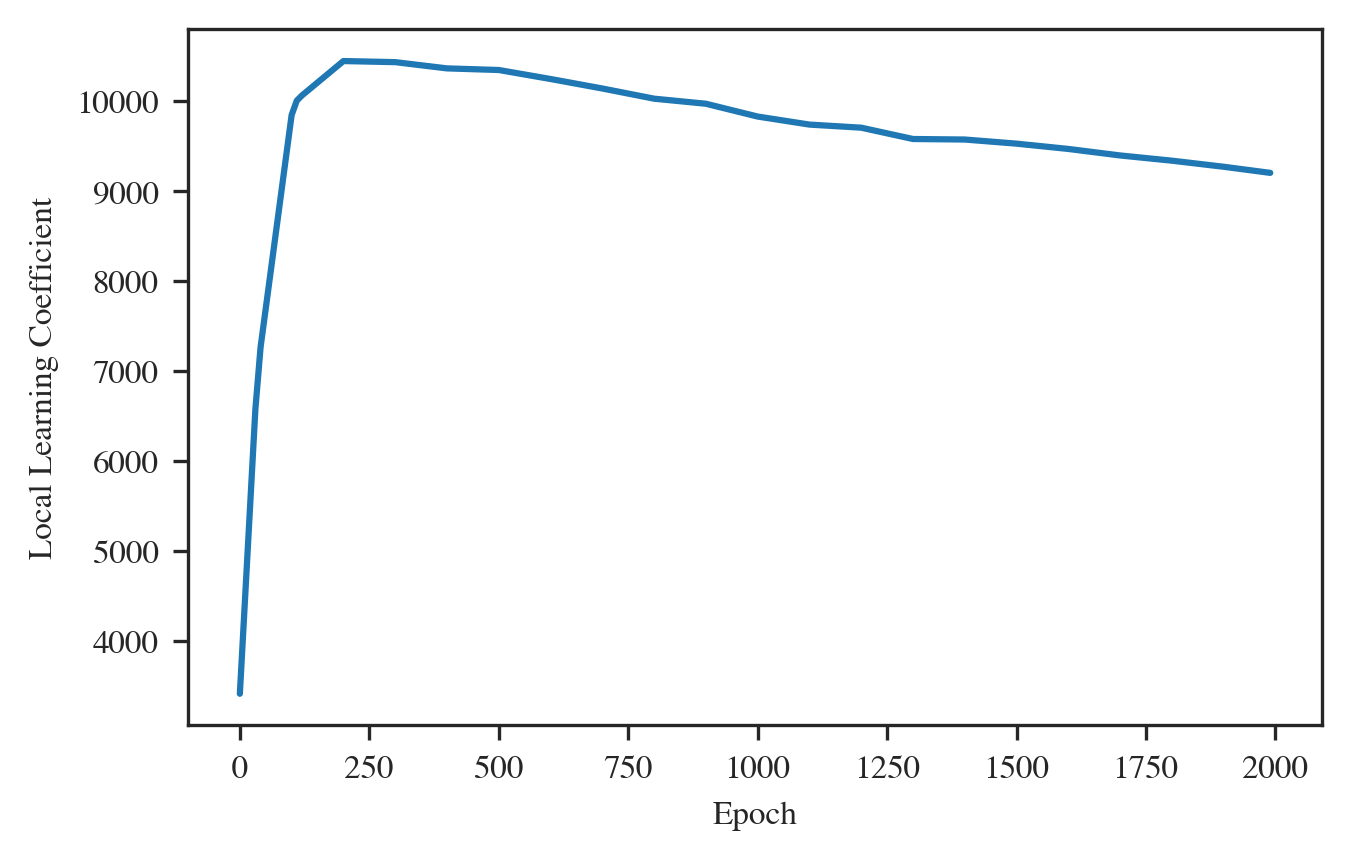

In [ ]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))

plt.plot(indice_list, ewdd_rlcts)
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Epoch')
plt.ylabel('Local Learning Coefficient')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.savefig(rlcts_path + "ewdd_rlcts.pdf")
plt.show()

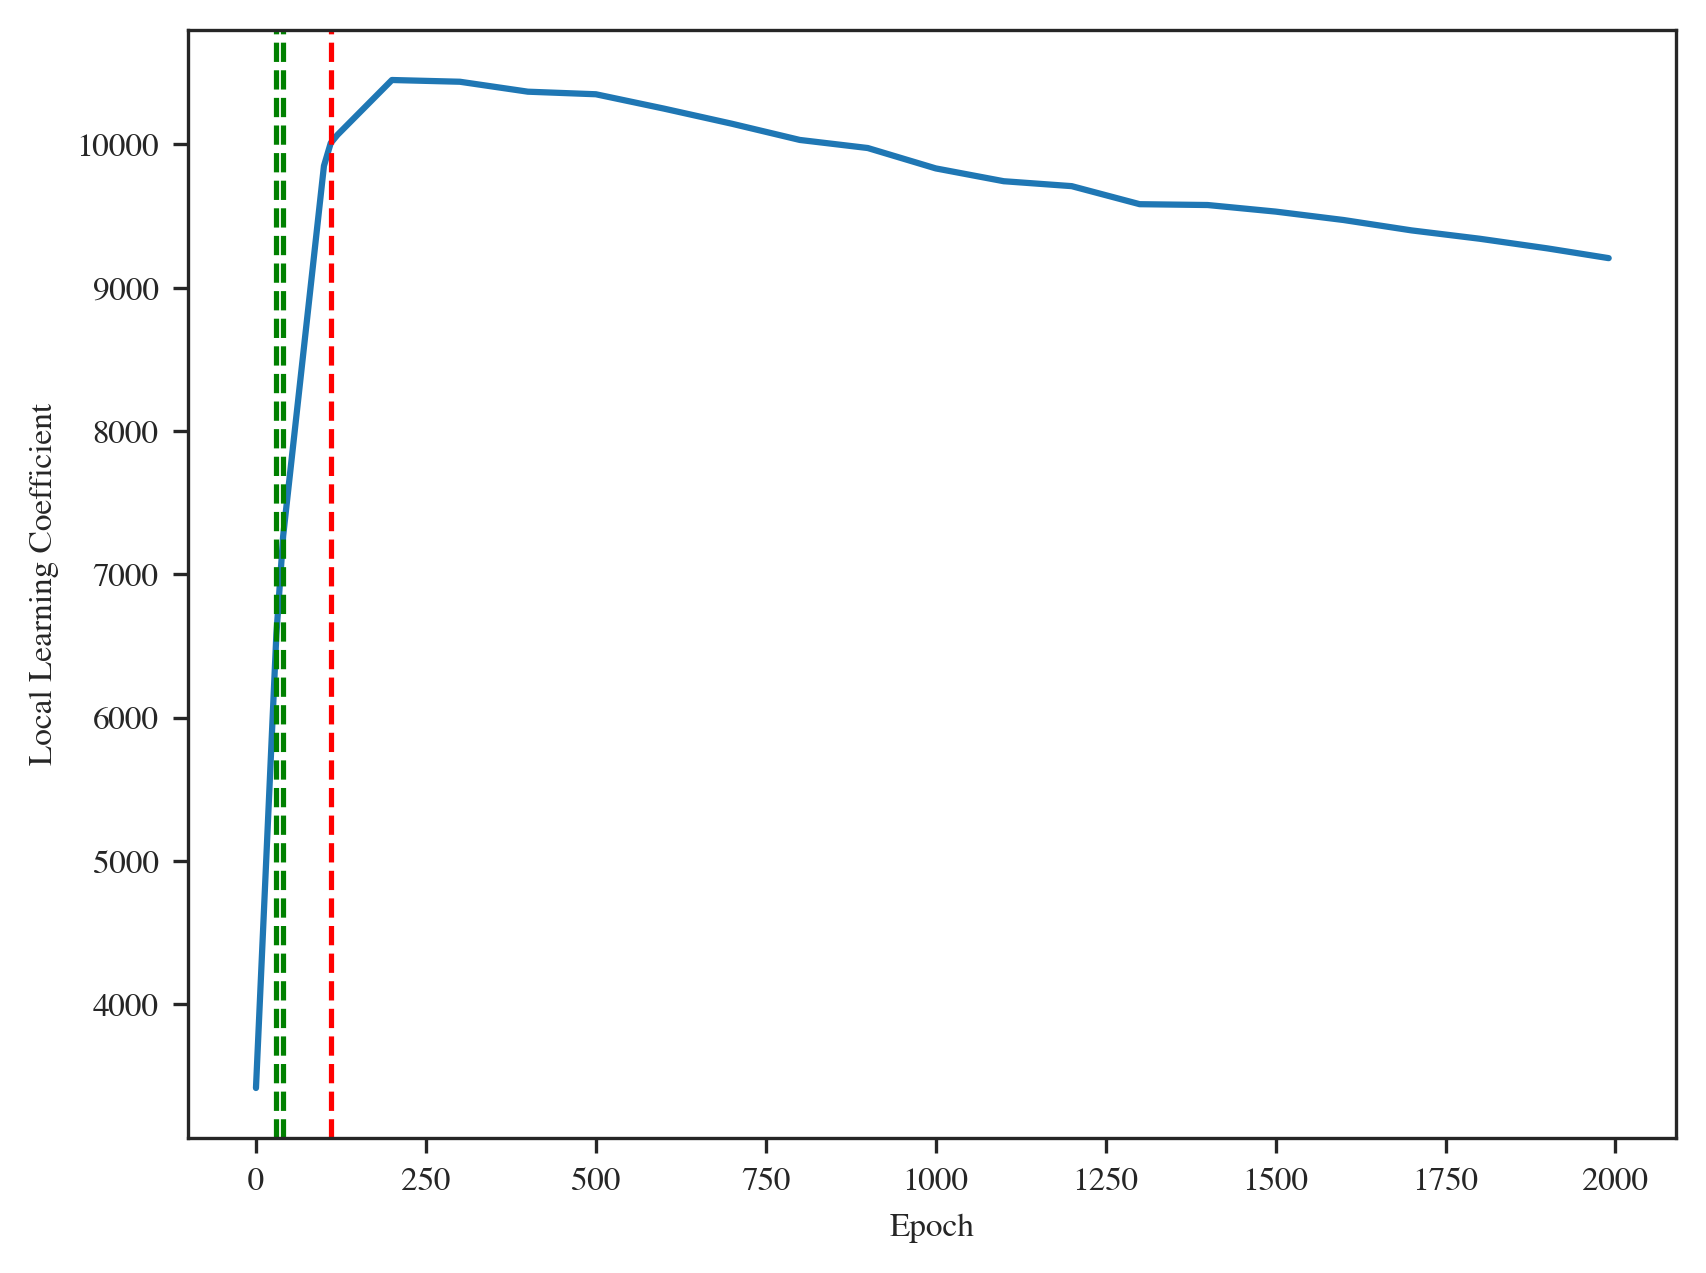

In [ ]:
max_index = 110
d_border_min_index = 30
u_border_min_index = 40


plt.plot(indice_list, ewdd_rlcts)
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.axvline(x=d_border_min_index, color='green', linestyle='--', linewidth = 1.25)
plt.axvline(x=u_border_min_index, color='green', linestyle='--', linewidth = 1.25)
plt.axvline(x=max_index, color='red', linestyle='--', linewidth = 1.25)
plt.xlabel('Epoch')
plt.ylabel('Local Learning Coefficient')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.savefig(rlcts_path + "points_ewdd_rlcts.pdf")
plt.show()

In [ ]:
np.argmax(ewdd_rlcts)

6

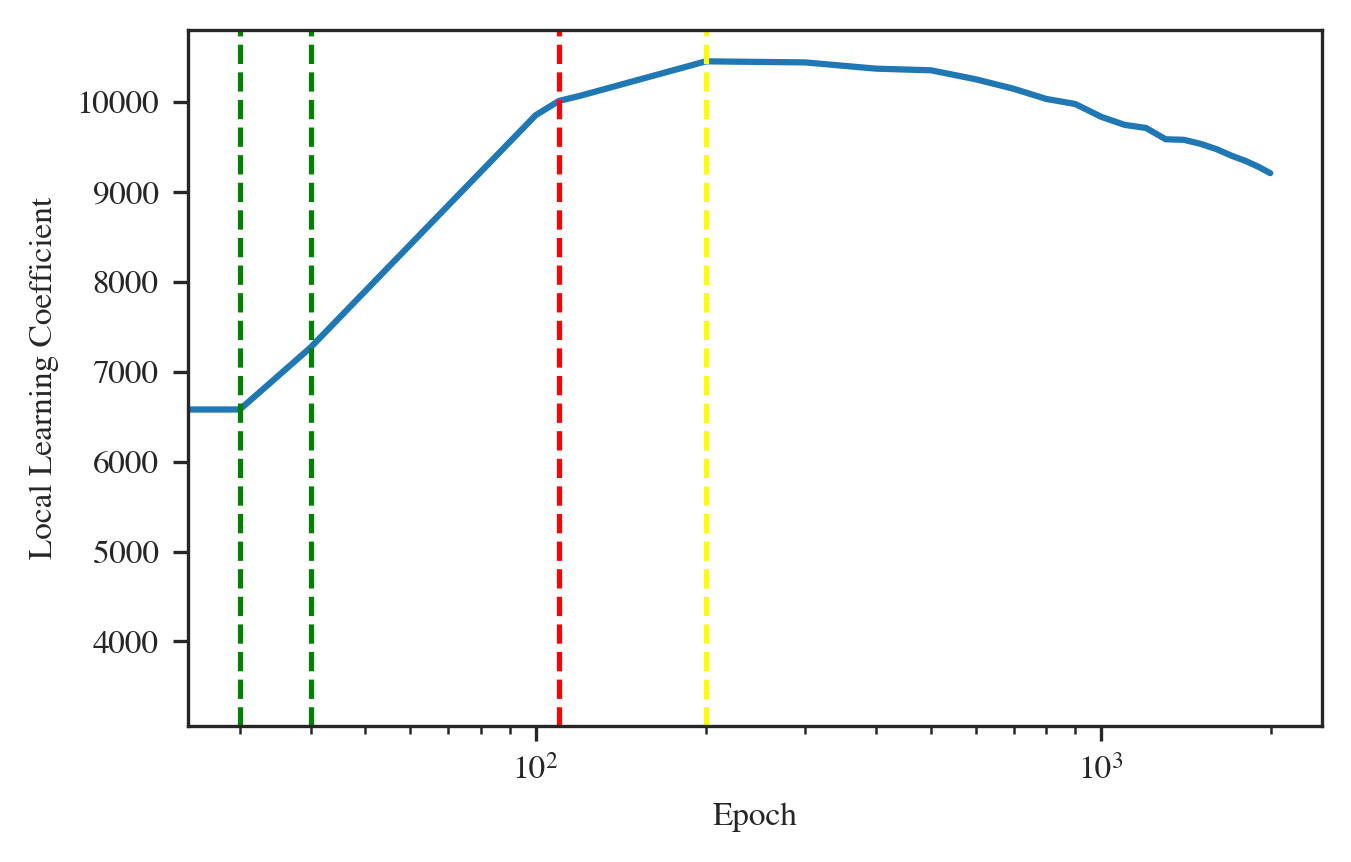

In [ ]:
max_index = 110
d_border_min_index = 30
u_border_min_index = 40
max_llc = 200

plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(indice_list, ewdd_rlcts)
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.axvline(x=d_border_min_index, color='green', linestyle='--', linewidth = 1.25)
plt.axvline(x=u_border_min_index, color='green', linestyle='--', linewidth = 1.25)
plt.axvline(x=max_index, color='red', linestyle='--', linewidth = 1.25)
plt.axvline(x=max_llc, color='yellow', linestyle='--', linewidth = 1.25)
plt.xlabel('Epoch')
plt.xscale('log')
plt.ylabel('Local Learning Coefficient')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.savefig(rlcts_path + "all_points_ewdd_rlcts.pdf")
plt.show()

In [ ]:
trained_model = '2000_'
e_test_error = trained_model + 'test_accs.csv' if not use_label_noise else trained_model + 'test_accs_with_label_noise.csv'
e_test_error = pd.read_csv(checkpoints_path + e_test_error).values
e_train_error = trained_model + 'train_accs.csv' if not use_label_noise else trained_model + 'train_accs_with_label_noise.csv'
e_train_error = pd.read_csv(checkpoints_path + e_train_error).values
e_epochs = np.arange(1, 2001)

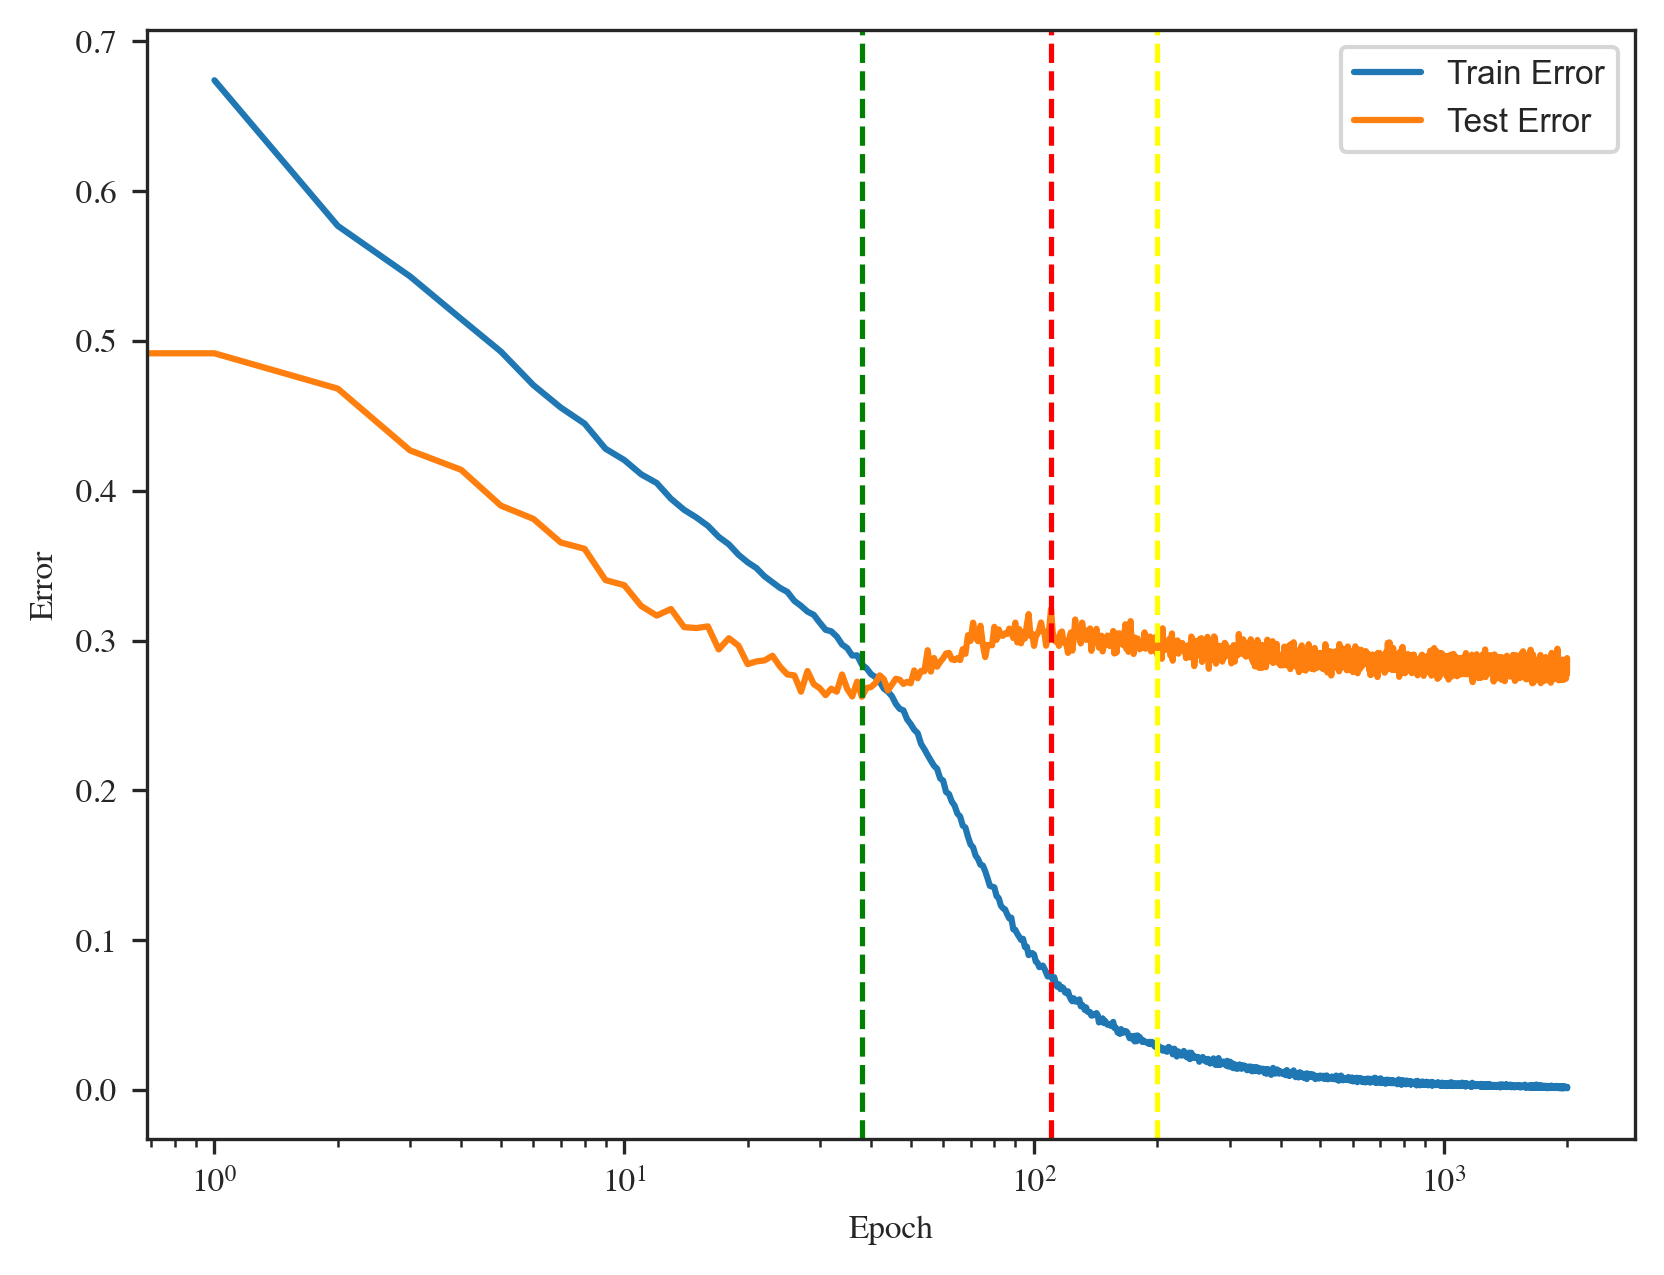

In [ ]:
fig, ax = plt.subplots()
ax.plot(e_epochs, 1-e_train_error, 1-e_test_error)
seaborn.set_style("ticks")
plt.xlabel('Epoch')
plt.xscale('log')
plt.ylabel('Error')
plt.legend(["Train Error", "Test Error"], loc="upper right")
min_index = np.argmin(1-e_test_error)
rest =(1-e_test_error)[min_index:]
max_index = min_index + np.argmax(rest)
ax.axvline(x=min_index, color='green', linestyle='--', linewidth = 1.25)
ax.axvline(x=max_index, color='red', linestyle='--', linewidth = 1.25)
plt.axvline(x=max_llc, color='yellow', linestyle='--', linewidth = 1.25)
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.savefig(rlcts_path + "ewdd_errors.pdf")
plt.show()

In [ ]:
concerned = list(range(0, 210, 10)) + list(range(1000, 2000, 100))
not_present = [110, 140, 1300, 1400]
for i in not_present:
    concerned.remove(i)

llcs = []

for i in concerned:
    checkpoint_llc = 'adam_checkpoint' + str(i) + '_rlcts.pt' if not use_label_noise else 'adam_checkpoint' + str(i) + '_with_noise' + '_rlcts.pt'
    trace = torch.load(rlcts_path + checkpoint_llc)
    llc = trace['llc/means'][-1]
    llcs.append(llc)

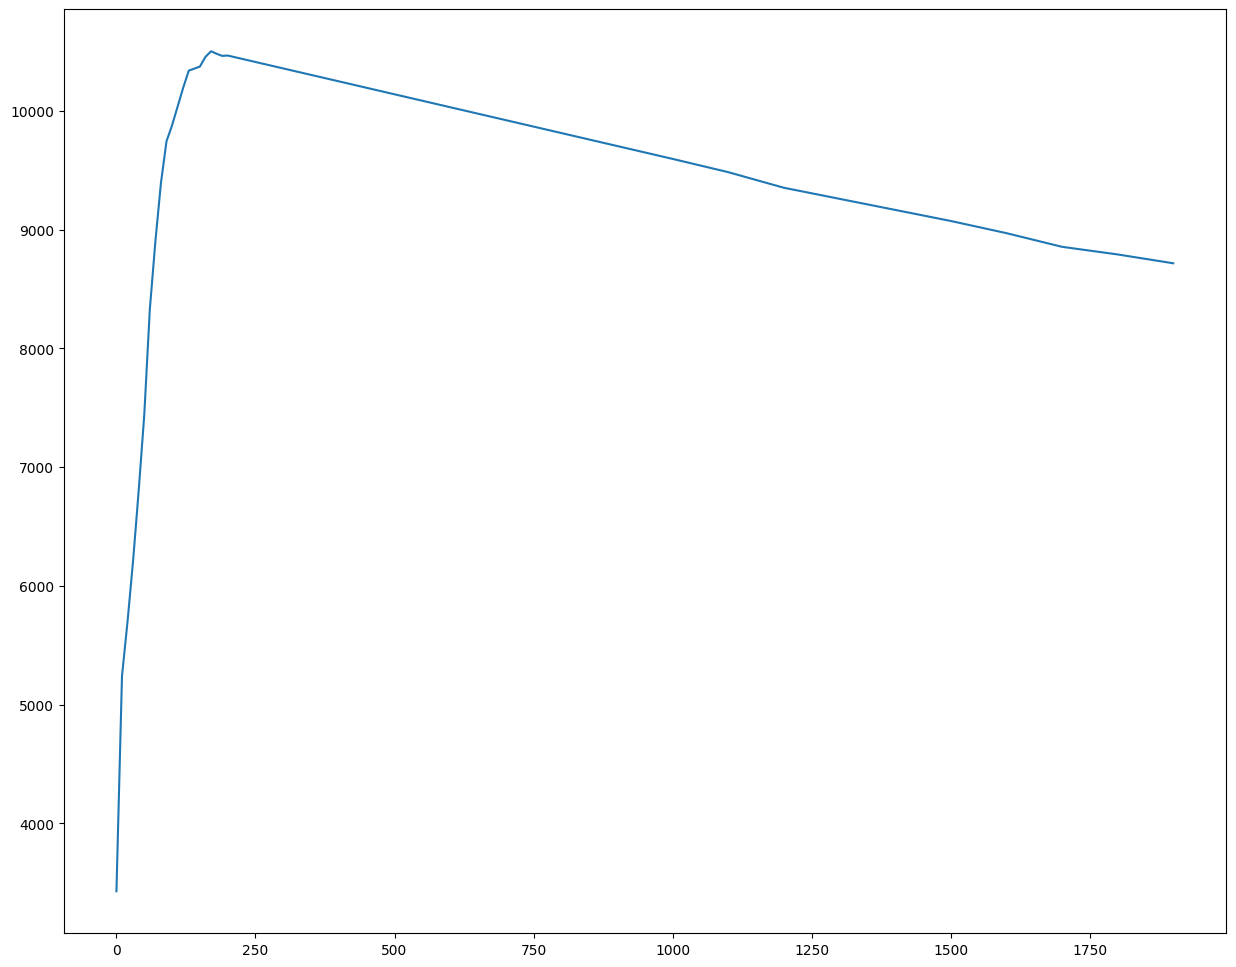

In [ ]:
plt.plot(concerned, llcs)